In [1]:
import torch
from transformers import SamProcessor, SamModel
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

/home/eranario/miniconda3/envs/diffusers/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_yolo_annotations(yolo_file):
    with open(yolo_file, 'r') as file:
        annotations = file.readlines()
    bboxes = []
    for annotation in annotations:
        parts = annotation.strip().split()
        x_center, y_center, width, height = map(float, parts[1:])
        bboxes.append((x_center, y_center, width, height))
    return bboxes

def draw_bboxes(image, bboxes):
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        x_center, y_center, width, height = bbox
        left = (x_center - width / 2) * image.width
        right = (x_center + width / 2) * image.width
        top = (y_center - height / 2) * image.height
        bottom = (y_center + height / 2) * image.height
        draw.rectangle([left, top, right, bottom], outline="red", width=2)
    return image

def create_binary_mask(mask, bboxes):
    # Create a blank binary mask
    binary_mask = np.zeros(mask.shape, dtype=np.uint8)

    # Apply the segmentation mask to the areas within the bounding boxes
    for bbox in bboxes:
        x_center, y_center, width, height = bbox
        left = int((x_center - width / 2) * mask.shape[1])
        right = int((x_center + width / 2) * mask.shape[1])
        top = int((y_center - height / 2) * mask.shape[0])
        bottom = int((y_center + height / 2) * mask.shape[0])
        
        # Mask within the bounding box
        binary_mask[top:bottom, left:right] = mask[top:bottom, left:right] == 1

    return binary_mask

def main(image_path, yolo_file):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    
    # Load YOLO annotations
    bboxes = load_yolo_annotations(yolo_file)
    
    # Draw bounding boxes on the image
    image_with_bboxes = draw_bboxes(image.copy(), bboxes)
    
    # Load SAM model and processor
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
    model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)

    # Prepare the image and bounding boxes for SAM
    input_points = []
    input_labels = []
    for bbox in bboxes:
        x_center, y_center, width, height = bbox
        x = x_center * image.width
        y = y_center * image.height
        input_points.append([x, y])
        input_labels.append(1)  # Positive label for foreground

    inputs = processor(image, input_points=[input_points], input_labels=[input_labels], return_tensors="pt").to(device)

    # Perform segmentation
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the segmentation masks
    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
    )[0]  # Get the first batch

    # Ensure the mask is 2D
    masks = masks.squeeze().numpy()  # Squeeze to remove extra dimensions
    if masks.ndim == 3 and masks.shape[0] == 1:  # Handle case where mask has extra channel dimension
        masks = masks[0]
    elif masks.ndim == 3 and masks.shape[0] == 3:  # If mask has three channels, convert to grayscale
        masks = np.mean(masks, axis=0)

    # Create the binary mask
    binary_mask = create_binary_mask(masks, bboxes)

    # Plot the results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_with_bboxes)
    axes[0].set_title("Original Image with BBoxes")
    
    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title("Binary Segmentation Mask")
    plt.show()

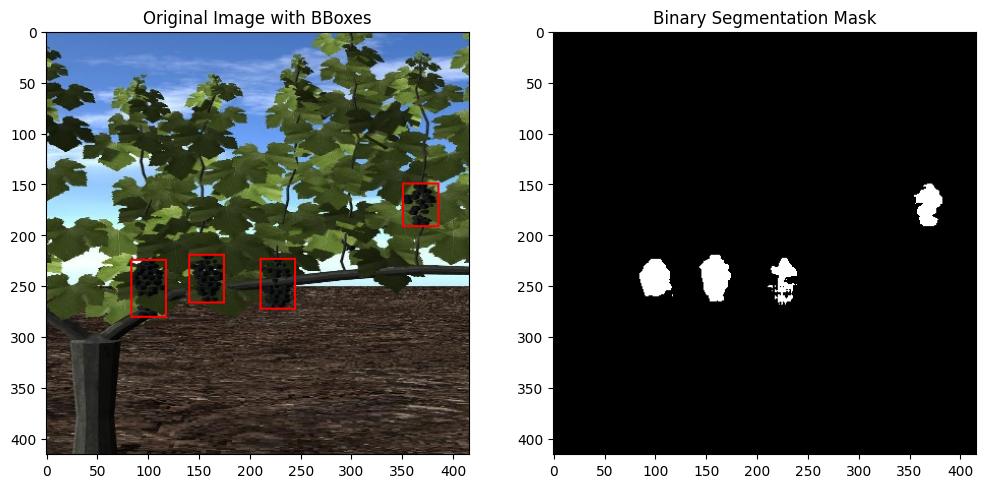

In [3]:
image_path = "/data2/eranario/data/Borden-Day2Night/train/00001.jpg"
yolo_file = "/data2/eranario/data/yolo_grl_data/BordenNight/Synthetic/labels/00001.txt"
main(image_path, yolo_file)